In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pandas as pd
from datetime import datetime
import time
import os
import gzip
import numpy as np
from shapely.geometry import Point
import warnings 
from tqdm import tqdm
import csv

warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data from 1980-2020
shapefile_path = "../data/National_USFS_Fire_Occurrence_Point_FL/usfs_fire_occurrence_cleaned_1980_2020.shp"
gdf = gpd.read_file(shapefile_path)

weather = pd.read_csv('../data/weather_data_per_fire.csv')
elevation = pd.read_csv('../data/elevations_per_fire.csv')
merged = weather.merge(elevation, on='OBJECTID').merge(gdf, on='OBJECTID')

In [ ]:
# SUB Question 1
###############################################

###############################################

In [13]:
merged['DISCOVERYD'] = pd.to_datetime(merged['DISCOVERYD'], errors='coerce')
merged['FIREOUTDAT'] = pd.to_datetime(merged['FIREOUTDAT'], errors='coerce')
merged['DURATION'] = (merged['FIREOUTDAT'] - merged['DISCOVERYD']).dt.days
merged = merged[merged['DURATION'] >= 0]
merged = merged[merged['DURATION'] <= 300]

# filter relevant data
weather_data = merged[['TEMPERATURE_AVERAGE', 'PRESSURE', 'WIND_SPEED', 'DURATION', 'PRECIPITATION']].dropna()
# weather_data = merged[['TEMPERATURE_AVERAGE', 'DURATION']].dropna()
# feature engineering
weather_data['TEMPERATURE_CATEGORY'] = pd.cut(weather_data['TEMPERATURE_AVERAGE'], bins=[0, 20, 40, 60], labels=["Low", "Medium", "High"])

# target variable
y = weather_data['DURATION']
#  predictors
X = weather_data[['TEMPERATURE_AVERAGE', 'PRESSURE', 'WIND_SPEED', 'PRECIPITATION']]

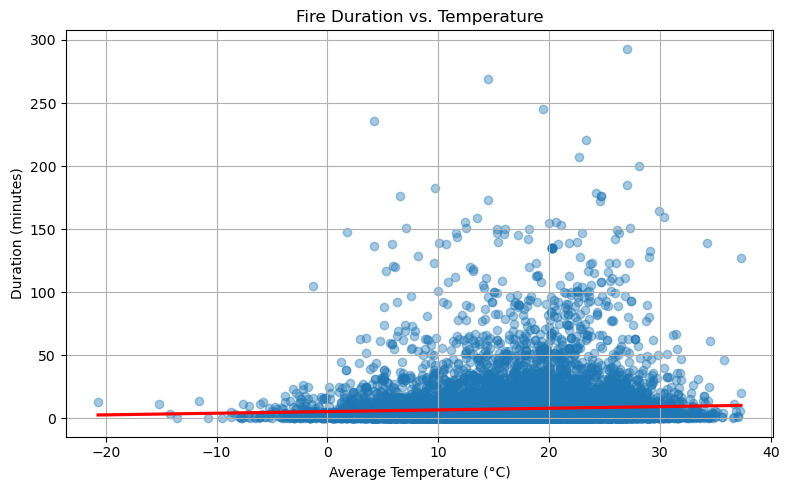

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.regplot(
    data=merged, 
    x='TEMPERATURE_AVERAGE', 
    y='DURATION', 
    scatter_kws={'alpha':0.4}, 
    line_kws={'color':'red'}
)
plt.title('Fire Duration vs. Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Duration (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate
y_pred = model.predict(X_test)

# RMSE and R-squared
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 14.45
R²: 0.04


In [ ]:
# SUB Question 2
###############################################

###############################################

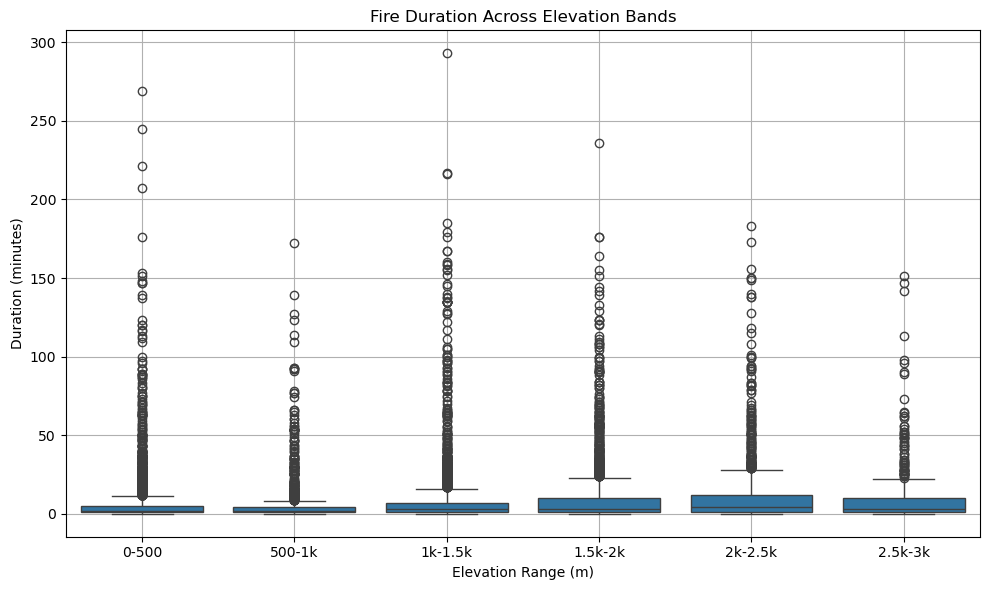

  ELEVATION_BIN  count       mean  median        std    max
0         0-500   5410   5.380037     2.0  13.263298  269.0
1        500-1k   1779   5.374930     2.0  12.574299  172.0
2       1k-1.5k   3329   8.190448     3.0  19.257345  293.0
3       1.5k-2k   2727   9.691969     3.0  18.693136  236.0
4       2k-2.5k   1317  11.220197     4.0  20.546710  183.0
5       2.5k-3k    570   9.319298     3.0  17.932106  151.0
\begin{table}
\caption{Fire Duration Across Elevation Bands}
\label{tab:elevation_duration}
\begin{tabular}{lrrrrr}
\toprule
ELEVATION_BIN & count & mean & median & std & max \\
\midrule
0-500 & 5410 & 5.38 & 2.00 & 13.26 & 269.00 \\
500-1k & 1779 & 5.37 & 2.00 & 12.57 & 172.00 \\
1k-1.5k & 3329 & 8.19 & 3.00 & 19.26 & 293.00 \\
1.5k-2k & 2727 & 9.69 & 3.00 & 18.69 & 236.00 \\
2k-2.5k & 1317 & 11.22 & 4.00 & 20.55 & 183.00 \\
2.5k-3k & 570 & 9.32 & 3.00 & 17.93 & 151.00 \\
\bottomrule
\end{tabular}
\end{table}



In [25]:
# Create elevation bins
merged['ELEVATION_BIN'] = pd.cut(merged['ELEVATION'], bins=[0, 500, 1000, 1500, 2000, 2500, 3000], labels=['0-500','500-1k','1k-1.5k','1.5k-2k','2k-2.5k','2.5k-3k'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='ELEVATION_BIN', y='DURATION')
plt.title('Fire Duration Across Elevation Bands')
plt.xlabel('Elevation Range (m)')
plt.ylabel('Duration (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

elevation_duration = merged.dropna(subset=['DURATION', 'ELEVATION_BIN'])

duration_summary = elevation_duration.groupby('ELEVATION_BIN')['DURATION'].agg(['count', 'mean', 'median', 'std', 'max']).reset_index()

print(duration_summary)

latex_table = duration_summary.to_latex(index=False, float_format="%.2f", caption="Fire Duration Across Elevation Bands", label="tab:elevation_duration")
print(latex_table)

Summary of TOTALACRES by Elevation Band:
ELEVATION_BIN  count   mean  median      std      max
        0-500   5391  40.11     0.5  1326.38  92682.0
       500-1k   1777 131.18     0.1  2959.90 115997.0
      1k-1.5k   3328  81.15     0.1  1505.57  48443.0
      1.5k-2k   2722 250.44     0.1  5072.88 229651.0
      2k-2.5k   1312 419.79     0.1 11453.40 412050.0
      2.5k-3k    570 139.84     0.1  1662.22  28142.0
\begin{table}
\caption{Fire Duration Across Elevation Bands}
\label{tab:elevation_duration}
\begin{tabular}{lrrrrr}
\toprule
ELEVATION_BIN & count & mean & median & std & max \\
\midrule
0-500 & 5391 & 40.11 & 0.50 & 1326.38 & 92682.00 \\
500-1k & 1777 & 131.18 & 0.10 & 2959.90 & 115997.00 \\
1k-1.5k & 3328 & 81.15 & 0.10 & 1505.57 & 48443.00 \\
1.5k-2k & 2722 & 250.44 & 0.10 & 5072.88 & 229651.00 \\
2k-2.5k & 1312 & 419.79 & 0.10 & 11453.40 & 412050.00 \\
2.5k-3k & 570 & 139.84 & 0.10 & 1662.22 & 28142.00 \\
\bottomrule
\end{tabular}
\end{table}


📈 ANOVA Results:
F-statist

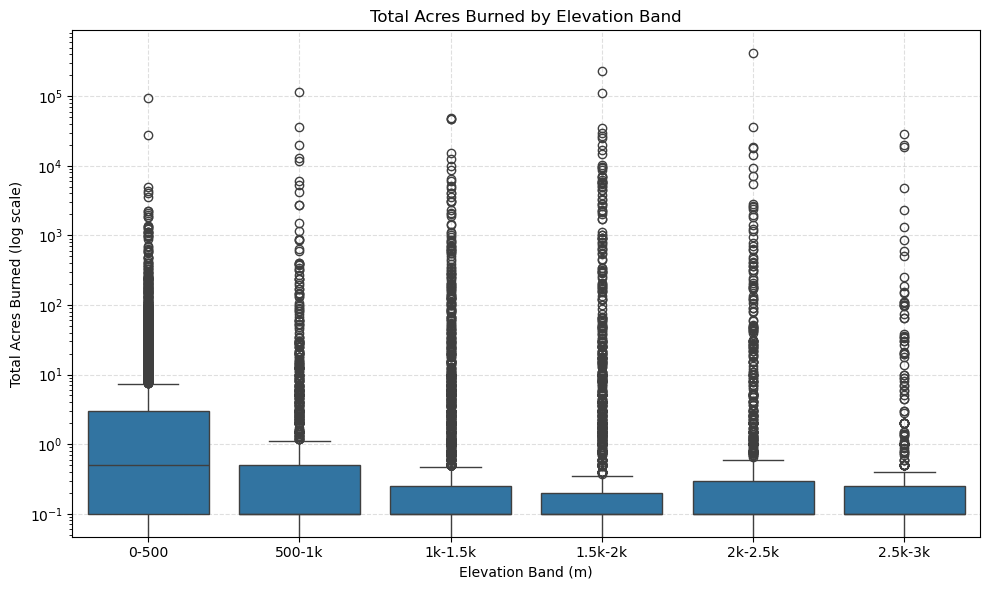

In [27]:
from scipy.stats import f_oneway

elev_acres = merged.dropna(subset=['TOTALACRES', 'ELEVATION_BIN'])

acres_summary = elev_acres.groupby('ELEVATION_BIN')['TOTALACRES'] \
    .agg(['count', 'mean', 'median', 'std', 'max']).reset_index().round(2)

print("Summary of TOTALACRES by Elevation Band:")
print(acres_summary.to_string(index=False))

latex_table = acres_summary.to_latex(index=False, float_format="%.2f", caption="Fire Duration Across Elevation Bands", label="tab:elevation_duration")
print(latex_table)

groups = [group['TOTALACRES'].values for name, group in elev_acres.groupby('ELEVATION_BIN')]
f_stat, p_val = f_oneway(*groups)

print(f"\n📈 ANOVA Results:")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.5f}")

plt.figure(figsize=(10, 6))
sns.boxplot(data=elev_acres, x='ELEVATION_BIN', y='TOTALACRES')
plt.yscale('log')  # Use log scale to handle extreme values
plt.title('Total Acres Burned by Elevation Band')
plt.xlabel('Elevation Band (m)')
plt.ylabel('Total Acres Burned (log scale)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [31]:
elevation_data = merged[['ELEVATION', 'DURATION']].dropna()
y_elevation = elevation_data['DURATION']
X_elevation = elevation_data[['ELEVATION']]

In [33]:
X_train_elevation, X_test_elevation, y_train_elevation, y_test_elevation = train_test_split(X_elevation, y_elevation, test_size=0.2, random_state=42)

model_elevation = LinearRegression()
model_elevation.fit(X_train_elevation, y_train_elevation)

y_pred_elevation = model_elevation.predict(X_test_elevation)

rmse_elevation = mean_squared_error(y_test_elevation, y_pred_elevation, squared=False)
r2_elevation = r2_score(y_test_elevation, y_pred_elevation)

print(f"RMSE: {rmse_elevation:.2f}")
print(f"R²: {r2_elevation:.2f}")

RMSE: 15.45
R²: 0.01


In [ ]:
# SUB Question 3
###############################################

###############################################

In [35]:
# Define target variable (for classification: fire occurrence)
merged['FIRE_OCCURRENCE'] = merged['DURATION'].apply(lambda x: 1 if x > 0 else 0)

# Define features
X_ml = merged[['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']]

# Define target for classification (fire occurrence)
y_ml = merged['FIRE_OCCURRENCE']

In [37]:
# Machine learning model (Random Forest Classifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_ml, y_train_ml)

# Predict on test data
y_pred_ml = rf_model.predict(X_test_ml)

# Evaluate model
print(confusion_matrix(y_test_ml, y_pred_ml))
print(classification_report(y_test_ml, y_pred_ml))

[[  78  508]
 [  85 2519]]
              precision    recall  f1-score   support

           0       0.48      0.13      0.21       586
           1       0.83      0.97      0.89      2604

    accuracy                           0.81      3190
   macro avg       0.66      0.55      0.55      3190
weighted avg       0.77      0.81      0.77      3190



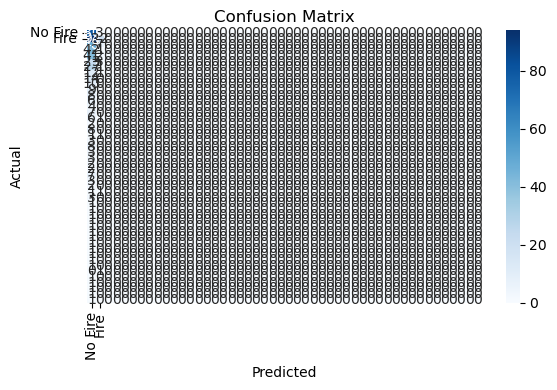

              precision    recall  f1-score   support

         0.0       0.16      0.96      0.28        83
         1.0       0.50      0.19      0.28       116
         2.0       0.00      0.00      0.00        55
         3.0       0.00      0.00      0.00        43
         4.0       0.00      0.00      0.00        43
         5.0       0.00      0.00      0.00        26
         6.0       0.00      0.00      0.00        28
         7.0       0.00      0.00      0.00        13
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        10
        10.0       0.00      0.00      0.00         9
        11.0       0.00      0.00      0.00         8
        12.0       0.00      0.00      0.00         6
        13.0       0.00      0.00      0.00         4
        14.0       0.00      0.00      0.00         7
        15.0       0.00      0.00      0.00         7
        16.0       0.00      0.00      0.00         2
        17.0       0.00    

C:\Users\gahot\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gahot\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gahot\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]

y_pred_binary = (y_pred_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'],
            yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_binary))


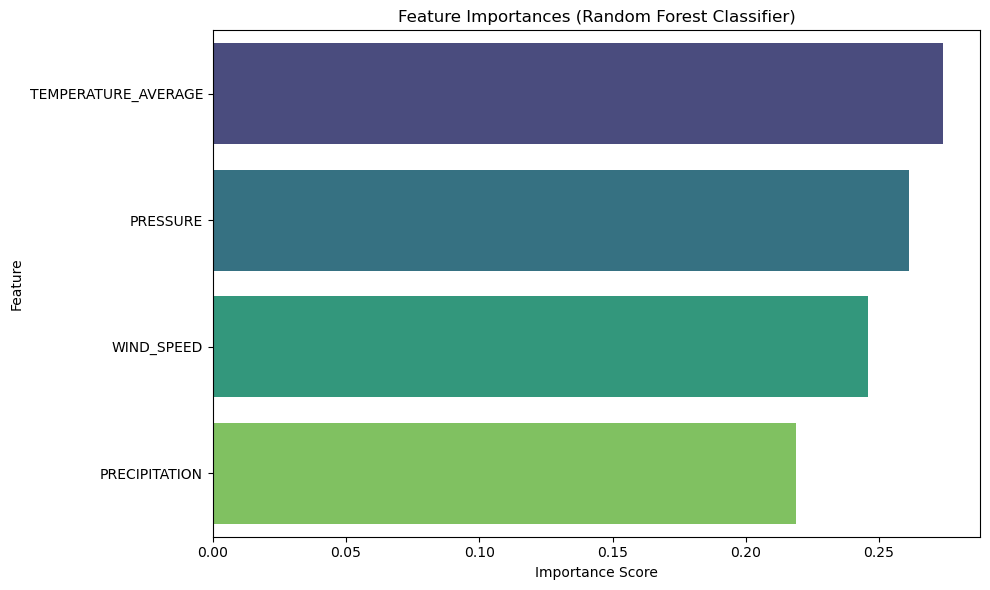

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

importances = clf.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('Feature Importances (Random Forest Classifier)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_probs = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


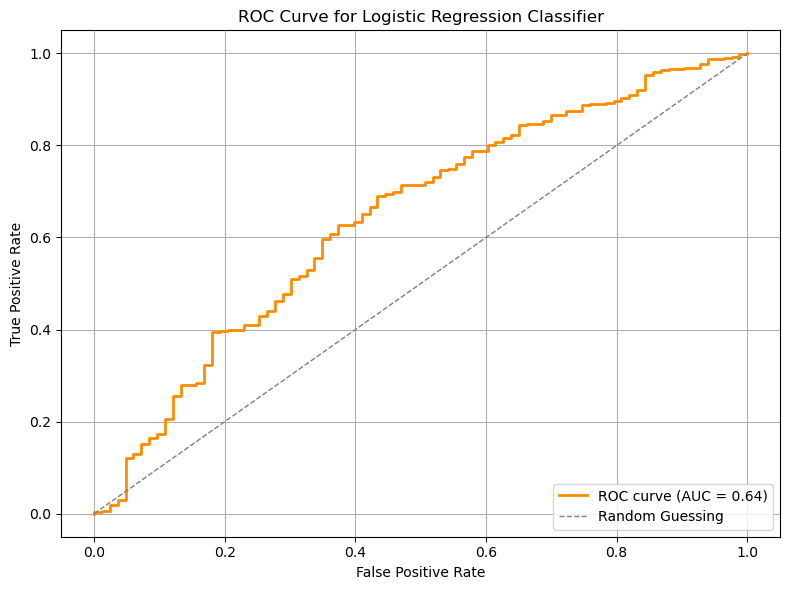

In [205]:
from sklearn.model_selection import train_test_split

merged['fire_occurred'] = (merged['DURATION'] > 0).astype(int)

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
X = merged[features]
y = merged['fire_occurred']  # binary target

# Drop missing values if needed
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



In [211]:
import pandas as pd
from scipy.stats import ttest_ind

# merged['FIRE_OCCURRENCE'] = merged['TEMPERATURE_AVERAGE'].apply(lambda x: 1 if x > 0 else 0)
# 1. Prepare your two groups
temps_fire     = merged.loc[merged['FIRE_OCCURRENCE'] == 1, 'TEMPERATURE_AVERAGE']
temps_no_fire  = merged.loc[merged['FIRE_OCCURRENCE'] == 0, 'TEMPERATURE_AVERAGE']

# 2. Inspect group sizes
print("N (fire days):",    temps_fire.shape[0])
print("N (no‐fire days):", temps_no_fire.shape[0])

# 3. Run Welch’s t‑test (does not assume equal variances)
stat, pvalue = ttest_ind(temps_fire, temps_no_fire, equal_var=False, nan_policy='omit')

print(f"T-statistic: {stat:.3f}")
print(f"P-value:     {pvalue:.5f}")

N (fire days): 12951
N (no‐fire days): 2999
T-statistic: 7.410
P-value:     0.00000
